In [14]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
from tqdm import tqdm
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
from utilities import LrUtilities
import torch.nn.functional as F


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_data = torchvision.datasets.CIFAR10(root="data/",download=True, train=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root="data/",download=True, train=False, transform=transform)
classes = ("Airplanes", "Cars", "Birds", "Cats", "Deer", "Dogs", "Frogs", "Horses", "Ships", "Trucks")

Files already downloaded and verified
Files already downloaded and verified


In [4]:
display_data = torchvision.datasets.CIFAR10(root="data/",download=True, train=True)

Files already downloaded and verified


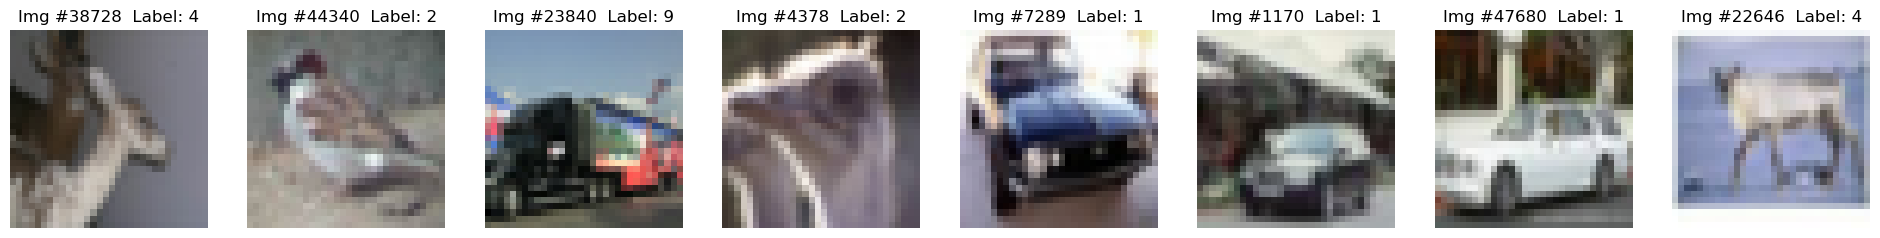

In [5]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_data), size=N_IMGS)

for i, n in enumerate(ids):
    img = display_data[n][0]#.numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {display_data[n][1]}")
    ax[i].axis("off")
plt.show()

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Base Model

In [8]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1,padding=1)
        self.pool = torch.nn.MaxPool2d(2,stride=2)
        self.fc1 = torch.nn.Linear(256 * 4 * 4, 128)  # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10)  # 10 output classes for CIFAR-10
        return
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x,start_dim=1,end_dim=-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
model = CNN_Model().to(device)
classes = ("Airplanes", "Cars", "Birds", "Cats", "Deer", "Dogs", "Frogs", "Horses", "Ships", "Trucks")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model,device,criterion,optimizer)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.16282.: 100%|██████████| 1563/1563 [00:12<00:00, 128.21it/s]


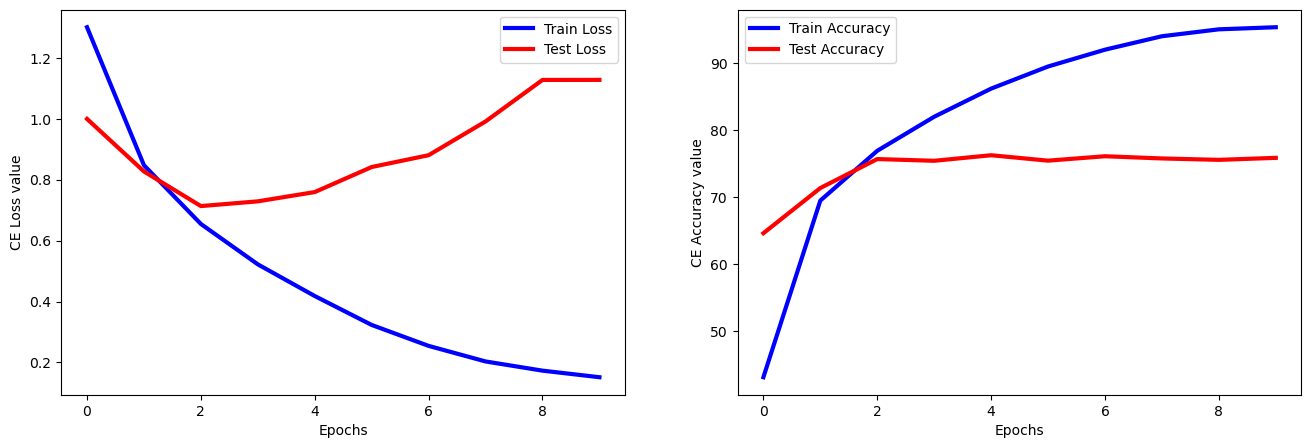

In [10]:
train.plot_loss_acc()

Validation accuracy: 75.89%
10000 10000


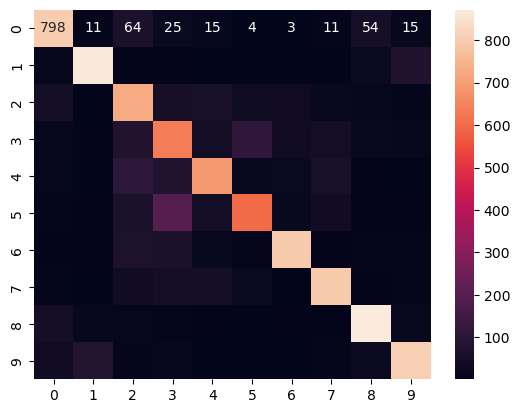

<Figure size 1200x700 with 0 Axes>

In [11]:
train.confusion_matrix() 

## With and Without DropOut

In [12]:
class CNN_WDrop_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_WDrop_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1,padding=1)
        self.pool = torch.nn.MaxPool2d(2,stride=2)
        self.fc1 = torch.nn.Linear(256 * 4 * 4, 128)  # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10)  # 10 output classes for CIFAR-10

        # Dropout layers with a dropout probability 
        self.dropout_conv = torch.nn.Dropout(0.25)  # Applied after convolutional layers
        self.dropout_fc = torch.nn.Dropout(0.5)     # Applied after fully connected layer
        return
    
    def forward(self, x):
        # Convolutional layers with dropout after each conv layer
        x = torch.relu(self.conv1(x))
        x = self.pool(self.dropout_conv(x))  
        
        x = torch.relu(self.conv2(x))
        x = self.pool(self.dropout_conv(x))  
        
        x = torch.relu(self.conv3(x))
        x = self.pool(self.dropout_conv(x)) 

        # Flatten layer
        x = torch.flatten(x, start_dim=1, end_dim=-1)

        # Fully connected layers with dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  
        x = self.fc2(x)

        return x

In [13]:
model = CNN_WDrop_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model,device,criterion,optimizer)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.37728.: 100%|██████████| 1563/1563 [00:12<00:00, 125.77it/s]


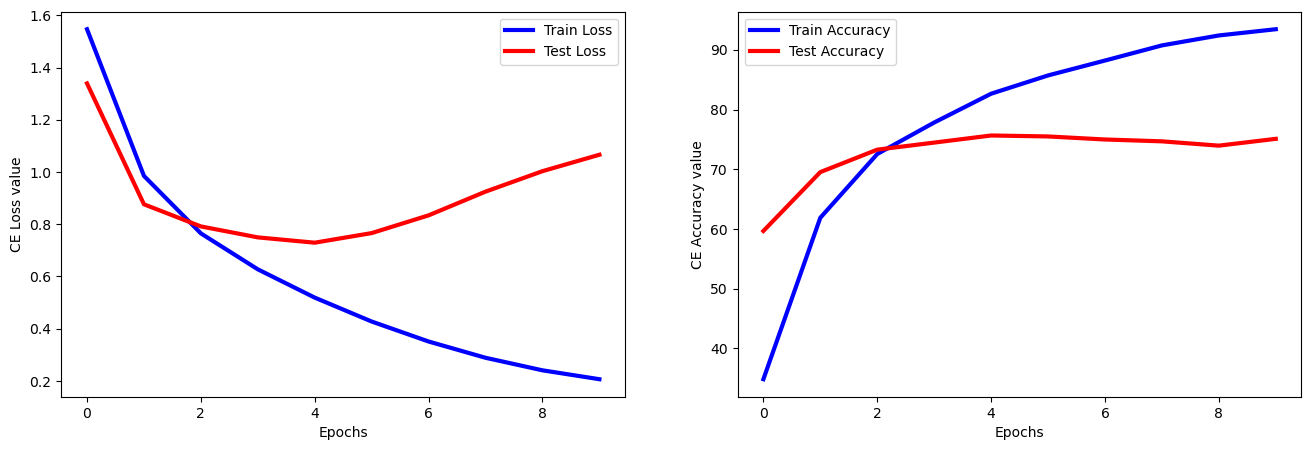

In [14]:
train.plot_loss_acc()

## With and Without L2-norm

In [15]:
model = CNN_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay =0.01)
train = Wrapper(model,device,criterion,optimizer)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.76590.: 100%|██████████| 1563/1563 [00:12<00:00, 126.03it/s]


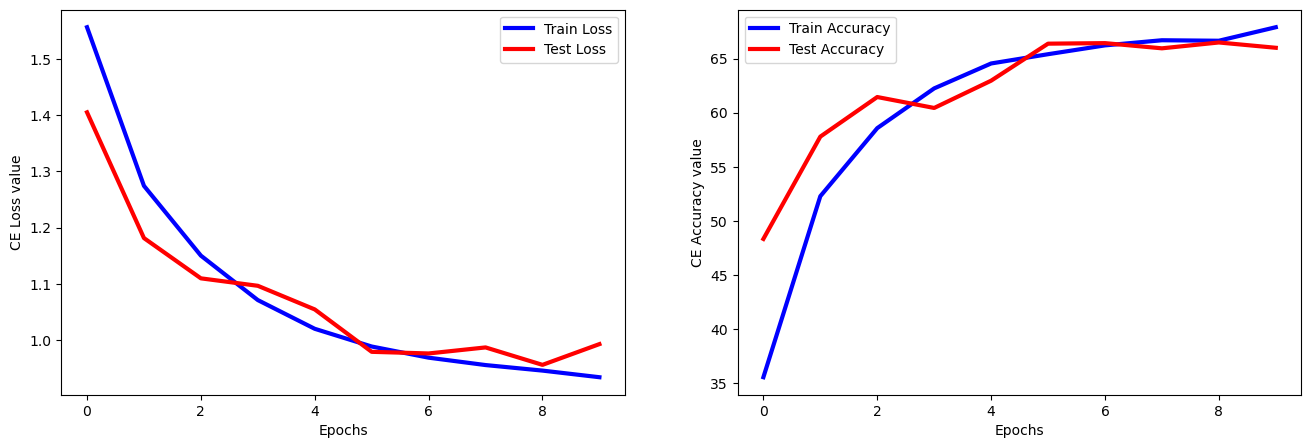

In [16]:
train.plot_loss_acc()

## with warmup scheduler

In [9]:
model = CNN_Model().to(device)
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = LrUtilities.WarmupScheduler(optimizer= opt,steps = 5)
train = Wrapper(model = model,device = device,criterion = crit,optimizer = opt,warmup_lr =scheduler)
train.train(20,trainloader,testloader,classes)

Epoch 20 Iter 1563: loss 0.02377.: 100%|██████████| 1563/1563 [00:11<00:00, 140.93it/s]


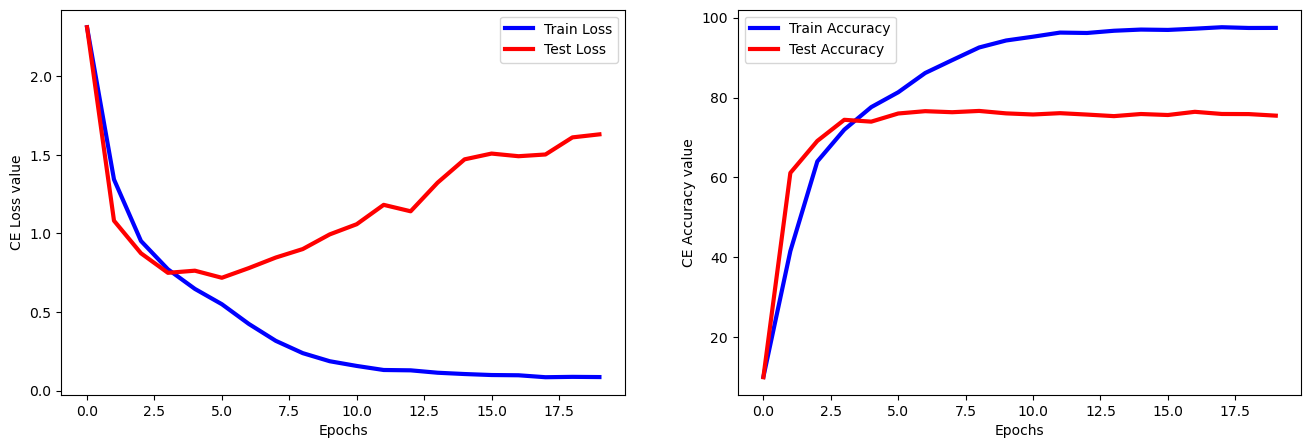

In [10]:
train.plot_loss_acc()

## with Cosine Annealing scheduler

In [9]:
model = CNN_Model().to(device)
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
sched = LrUtilities.CosineAnnealing(optimizer= opt)
train = Wrapper(model = model,device = device,criterion = crit,optimizer = opt,scheduler =sched)
train.train(20,trainloader,testloader,classes)

Epoch 20 Iter 1563: loss 0.00010.: 100%|██████████| 1563/1563 [00:13<00:00, 119.70it/s]


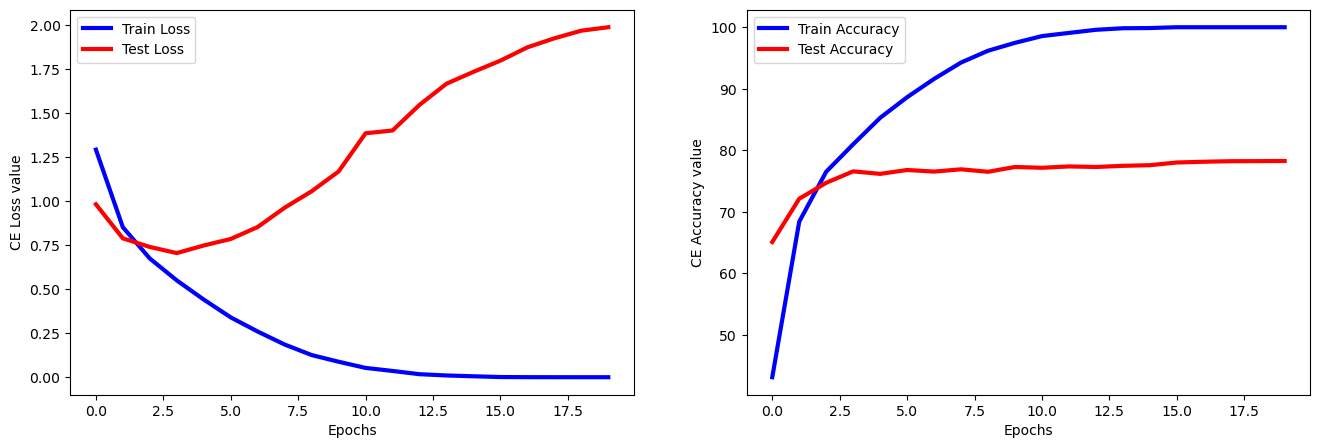

In [10]:
train.plot_loss_acc()

## Bonus ConvMixer

In [22]:
class ConvMixer(torch.nn.Module):
    def __init__(self,filters=256 , depth=8 , kernal=5 , patch_size=2 ):
        super().__init__()
        self.d = depth
        self.bn = torch.nn.BatchNorm2d(filters)
        self.cnn1 = torch.nn.Conv2d(3 , filters , (patch_size , patch_size) , stride=patch_size)
        self.bn1 = torch.nn.BatchNorm2d(filters)
        self.cnn2 = torch.nn.Conv2d(filters , filters , (kernal , kernal) , groups=filters , padding="same")
        self.bn2 = torch.nn.BatchNorm2d(filters)
        self.cnn3 = torch.nn.Conv2d(filters , filters , (1,1))
        self.pool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(filters , 10)

    def forward(self , x):
        x = self.bn(F.gelu(self.cnn1(x)))
        for i in range(self.d):
          x = self.bn1(F.gelu(self.cnn2(x)))+ x #residual step and depthwise convolution
          x = self.bn2(F.gelu(self.cnn3(x))) #pointwise convolution
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

In [23]:
model = ConvMixer().to(device)
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model = model,device = device,criterion = crit,optimizer = opt,scheduler =sched)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.43870.: 100%|██████████| 1563/1563 [00:23<00:00, 67.34it/s]


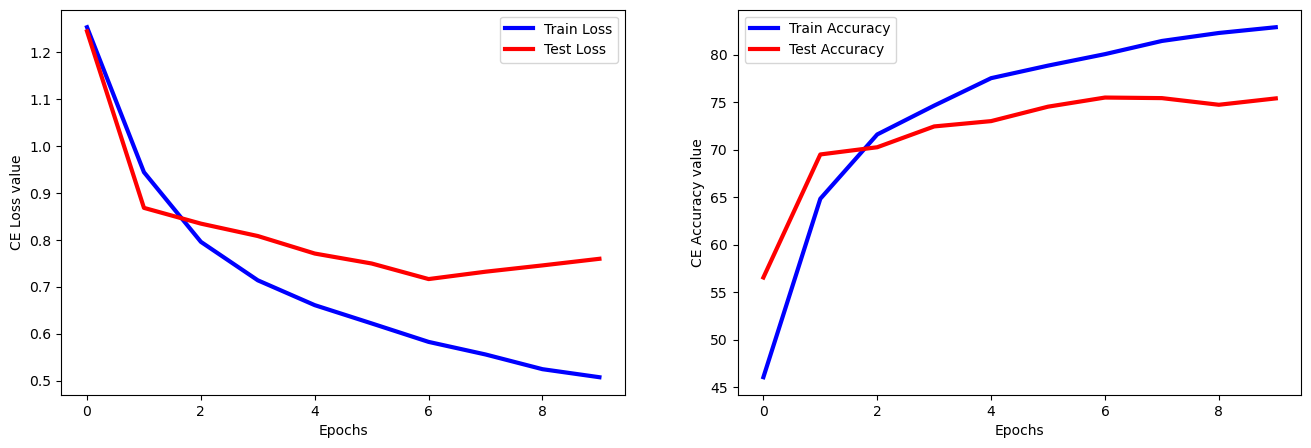

In [24]:
train.plot_loss_acc()

Validation accuracy: 75.39%
10000 10000


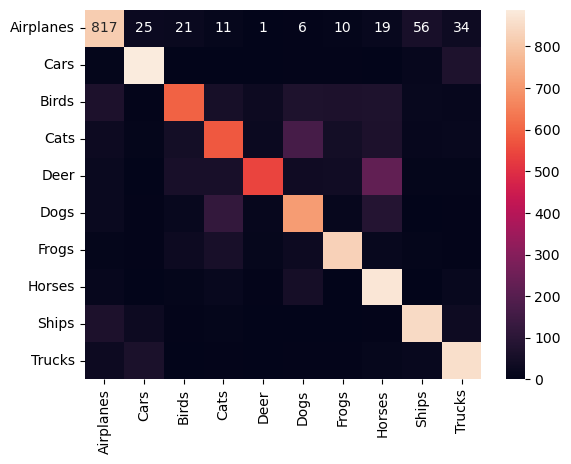

<Figure size 1200x700 with 0 Axes>

In [25]:
train.confusion_matrix()